Mahsa Raeisinezhad

**Instructions:**


1.  The work on this project should be entirely your own and no team work is allowed. No consulation with your classmates or anybody else is allowed.
2.  You need to run this project on Google Colab because of the required packages.
3. Please  provide your report in the form of a Python notebook, which contains your code and your results. Running the notebook should re-produce all the figures that are in your report.  Hand-written reports will receive no grade.



**Problem Setup:** The objective of this project is to use  physics-informed neural networks (PINNs) (**Method 1**) and physics-informed regression using linear basis functions (**Method 2**) to solve a forward and inverse heat transfer via conduction  in a plate. The schematic of the problem is shown below. The problem is assumed to be non-dimensionalized and therefore, no unit is used.  The plate geometry is a square with length $L=1$. The plate is heated with a heat source $q(x_1,x_2)$ centered at $(x_1^{(0)},x_2^{(0)})$. The heat source distribution is approximated by:
\begin{equation*}
q(x_1,x_2) = a \exp(-b (x_1-x_1^{(0)})^2-b (x_2-x_2^{(0)})^2), \qquad \text{(1)}
\end{equation*}
where $a$ and $b$ are constants. The plate boundaries are kept at a constant temperature of $T=T_b$.

|<img src="https://i.ibb.co/mrKGBvQ/Schematic.png" width="400">|
|-|
|Figure 1: Schematic of a two-dimensional conduction in a plate.|

The steady-state distribution of temperature is governed by
\begin{equation*}
    k(\frac{\partial^2{T}}{\partial x_1^2}+\frac{\partial^2{T}}{\partial x_2^2})+q(x_1,x_2)=0, \qquad \text{(2)}
\end{equation*}
where $T=T(x_1,x_2)$ is the temperature and $k$ is the plate conductivity. Let us assume we have some noisy temperature measurements at the boundary and at random interior points. Let us also assume that $a=250$, $b=20$, $x_1^{(0)}=\frac{1}{6}$, $x_2^{(0)}=\frac{1}{2}$, $T_b=0$ and $k=0.1$. In the following we adopt the generic notation of $y \leftarrow T$ and $x \leftarrow (x_1,x_2)$.  In this project you will build two kinds of regression models: (i) data-driven regression model; (ii) physics-informed regression model.

Download the *Project.ipynb* and *data.npz* from Canvas. The *data* contains the solution of Equation (2) for the above parameters. You only need to use the second cell to load the data.




**Method 1** (60 points)

Below you can also find the code for creating a feed-forward neural network with one layer and $m$ hidden units where $y(x; \mathbf{w}) = W^{(2)} h (W^{(1)} x + b^{(1)}) + b^{(2)}$ and **params** denotes all the weights and biases. In all parts of this project use *N_test=75, sigma=2* and the number of hidden units is *m=40*.

1. The **Forward** function evaluates the regression model for a given input corrdinates $x_1$ and $x_2$. This function has some missing lines. Complete the **Forward** function.

2. The **Loss** function evaluates the loss of the regression model for a given set of parameters. This function has some missing lines. Complete the **Loss** function for purely data-driven regression, i.e., at this stage physical model is not used in the regression.


3. Run the regression model in  the data-driven mode with **X_train** and **Y_train**. Out of the 225 training data points, 215 measurements are  taken at the boundaries and only 10 measurements are taken at the interior points.  Plot the contour lines of the temperature obtained from the regressed model and compare your results against the truth (*T* from *data.npz*).  Explain your results.

4. Modify the **Loss** function and add the physics-informed portion of the loss function to the loss. The **d2y_dx1** and **d2y_dx2** functions compute the laplacian of the **Forward** function with respect to the second ($x_1$) and third ($x_2$) inputs, which are equal to $\frac{\partial^2{T}}{\partial x_1^2}$ and $\frac{\partial^2{T}}{\partial x_2^2}$ terms in Equation (2).


5. Classical scientific computing techniques have great difficulty solving  partial/differential equations when boundary/initial conditions are noisy and/or are partly known. Use physics-informed regression (data+physics mode) to solve Equation (2) using noisy boundary/interior data. Use  the same setup as in Part 3 for data portion and network architecture and use *N_Model = 100* randomly distributed points to enforce the model. Plot the contour lines of the temperature using the regressed model and compare your results against the truth (*T* from *data.npz*).  Compare your result against that of Part 3, i.e., pure data-driven regression.

6. Compute the generalization error for the PINN that was built in Part 5. To this end, use **X_test** and **Y_test**. The number of test points should be equal to *N_test = 75*.  Plot the history of the generalization error as well as the training error versus iteration in one figure.

7. One of the favorable features of PINNs is their efficiency in solving *inverse* problems/parameter estimation. Assume that we did not know the conductivity of the plate, i.e., $k$ and use PINN to find $k$. Follow these steps: (i) Add $k$  to the weight vector. You need to change **Init** function. (ii) Modify the **Loss** function to ensure that $k$ is updated in each iteration. (iii) Run your program to estimate temperature and conductivity. Plot the history of $k$ versus optimization iterations by modifying the plot section of the loss function. Report the final value of $k$.

In [ ]:
! pip install optax


In [ ]:
import jax
import optax
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, grad
import matplotlib.pyplot as plt

key = jax.random.PRNGKey(2)

In [ ]:
data = jnp.load('data.npz')
X1, X2, T, I = data['X1'], data['X2'], data['T'], data['I']

L = 1
k = 0.1
N_test  = 75
N_Model = 100
sigma = 2

I_train, I_test = I[N_test:], I[:N_test]

X_train = jnp.hstack((X1.reshape(-1,1)[I_train], X2.reshape(-1,1)[I_train]))
Y_train = T.ravel()[I_train] + sigma*jax.random.normal(key, shape=(len(I_train),))

X_test = jnp.hstack((X1.reshape(-1,1)[I_test], X2.reshape(-1,1)[I_test]))
Y_test = T.ravel()[I_test]

X_model = L*jax.random.uniform(key, shape=(N_Model,2))

q = lambda X: 250*jnp.exp(-20*(X[:,0]-L/6)**2-20*(X[:,1]-L/2)**2)

Method 1: Part 1: Regression_Method_1

In [ ]:
def Init(units, key):
    params = []
    keys = jax.random.split(key, num=4)

    w1 = jax.random.uniform(keys[0], (2, units[0]), minval=-1.0, maxval=1.0)
    b1 = jax.random.uniform(keys[1], (units[0],),   minval=-1.0, maxval=1.0)
    params.append([w1,b1])

    w2 = jax.random.uniform(keys[2], (units[0], units[1]), minval=-1.0, maxval=1.0)
    b2 = jax.random.uniform(keys[3], (units[1],), minval=-1.0, maxval=1.0)

    params.append([w2,b2])
    return params


def Forward_NN_Method_1(params, x1, x2):

    input = jnp.hstack((x1.reshape(-1,1), x2.reshape(-1,1)))
    l1 = jnp.tanh(input @ params[0][0] + params[0][1])
    l2 = l1 @ params[1][0] + params[1][1]
    return l2.squeeze()


units, learning_rate, epochs = [40,1], 1e-4, 100000
params = Init(units, key)


@jit
def Loss_NN_Method_1(params, X_data, Y_data):

    loss = (1/N_test)*(jnp.mean((Y_train - Forward_NN_Method_1(params, X_train[:,0], X_train[:,1] ))**2))

    return loss



Gradients = grad(Loss_NN_Method_1)

params = Init(units, key)

In [ ]:
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

# The function "step" performs one step of the optimization - it updates the weights based on the gradient and it should be called in the optimization iterations. You do not need to change this function in this project.
# The function uses "adams", which is a gradient-based optimiation algorithm. It performs better than the vanilla gradient descent method.
# "params" is a list that contains all regression parameters.
# "opt_state" contains a set of optimization parameters that the algorithm uses. You do not need to use opt_state anywhere else.
# This is just used in the optimization iterations.
@jit
def step(params, opt_state):
    gradients = Gradients(params, X_train, Y_train)
    updates, opt_state = optimizer.update(gradients, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state


In [ ]:
MSE_Loss_Test_Data_NN_Method_1 = []
MSE_Loss_Train_Data_NN_Method_1 = []
for i in range(epochs):

    params, opt_state = step(params, opt_state)

    MSE_Loss_Test_Data_NN_Method_1.append(Loss_NN_Method_1(params, X_test, Y_test))
    MSE_Loss_Train_Data_NN_Method_1.append(Loss_NN_Method_1(params, X_train, Y_train))

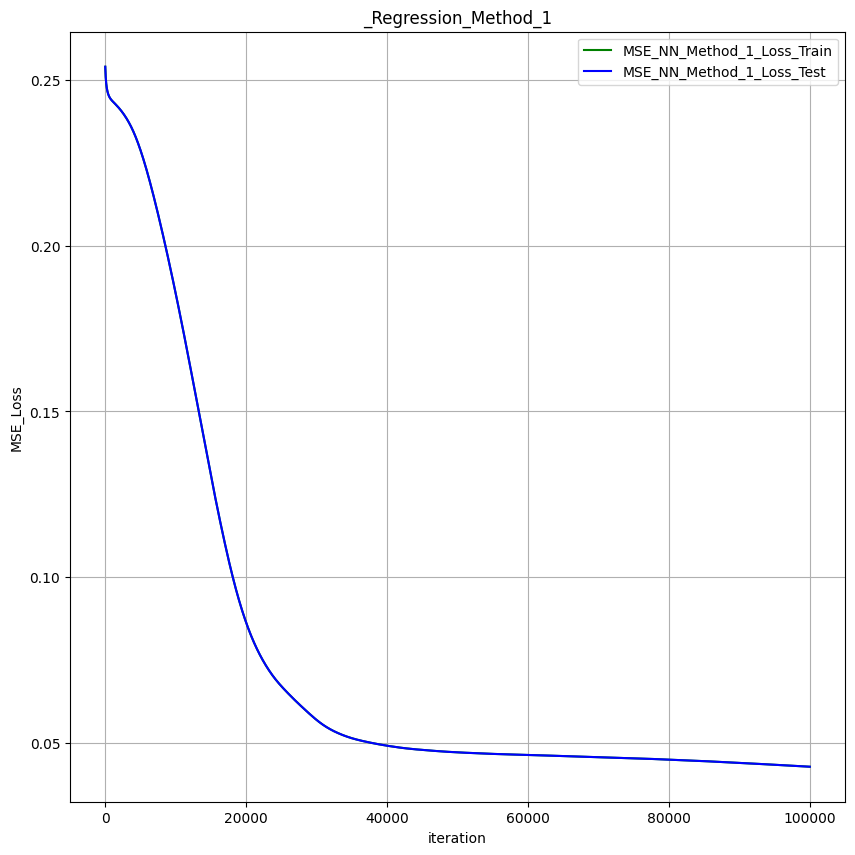

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

x__ = jnp.linspace(0, epochs, epochs)
ax.plot(x__, jnp.array(MSE_Loss_Train_Data_NN_Method_1), c='green')
ax.plot(x__, jnp.array(MSE_Loss_Test_Data_NN_Method_1), c='blue')
ax.set_xlabel('iteration')
ax.set_ylabel('MSE_Loss')
plt.title('_Regression_Method_1')
plt.legend([
  'MSE_NN_Method_1_Loss_Train',
  'MSE_NN_Method_1_Loss_Test',
])
plt.grid(True)
plt.show()

Text(0.5, 1.0, '_NN_Method_1')

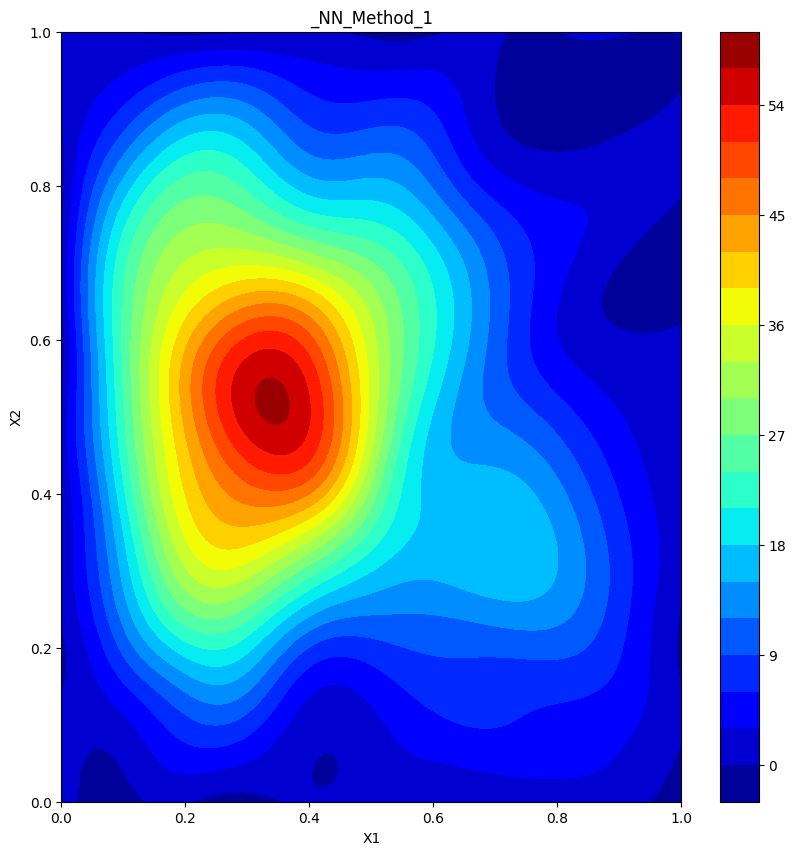

In [ ]:
Forward_NN_Method_1 = Forward_NN_Method_1(params, X1, X2)
Forward_NN_Method_1.shape
Forward_NN_ = Forward_NN_Method_1.reshape(101,101)
fig = plt.figure(figsize=(10,10))
plt.contourf(X1, X2, Forward_NN_, cmap='jet', levels = 20)
plt.colorbar()

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('_NN_Method_1')

Method 1: Part2: PINNS_Regression

In [ ]:
def Init(units, key):
    params = []
    keys = jax.random.split(key, num=4)

    w1 = jax.random.uniform(keys[0], (2, units[0]), minval=-1.0, maxval=1.0)
    b1 = jax.random.uniform(keys[1], (units[0],),   minval=-1.0, maxval=1.0)
    params.append([w1,b1])

    w2 = jax.random.uniform(keys[2], (units[0], units[1]), minval=-1.0, maxval=1.0)
    b2 = jax.random.uniform(keys[3], (units[1],), minval=-1.0, maxval=1.0)

    params.append([w2,b2])
    return params


def Forward_PINNS_Regression(params, x1, x2):

    input = jnp.hstack((x1.reshape(-1,1), x2.reshape(-1,1)))
    l1 = jnp.tanh(input @ params[0][0] + params[0][1])
    l2 = l1 @ params[1][0] + params[1][1]
    return l2.squeeze()


units, learning_rate, epochs = [40,1], 1e-4, 100000
params = Init(units, key)

In [ ]:
d2y_dx1 = jit(vmap(grad(grad(Forward_PINNS_Regression, 1), 1), in_axes=(None, 0, 0)))
d2y_dx2 = jit(vmap(grad(grad(Forward_PINNS_Regression, 2), 2), in_axes=(None, 0, 0)))
k = 0.1


def R_PINNS_Regression(params, X):
    R = (k)*(d2y_dx1(params, X[:,0], X[:,1]) + d2y_dx2(params, X[:,0], X[:,1])) + q(X)
    return R


@jit
def Loss_PINNS_Regression(params, X_data, Y_data, X):

    # loss = jax.numpy.linalg.norm((Y_data - Forward(params, X_data[:,0], X_data[:,1] ))) + (1/N_Model)*(jax.numpy.linalg.norm(R(params, X)))
    loss = (1/N_Model)*(jnp.mean((R_PINNS_Regression(params, X_model))**2)) + (1/N_test)*(jnp.mean((Y_train - Forward_PINNS_Regression(params, X_train[:,0], X_train[:,1] ))**2))
    return loss



Gradients = grad(Loss_PINNS_Regression)

params = Init(units, key)



In [ ]:
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

# The function "step" performs one step of the optimization - it updates the weights based on the gradient and it should be called in the optimization iterations. You do not need to change this function in this project.
# The function uses "adams", which is a gradient-based optimiation algorithm. It performs better than the vanilla gradient descent method.
# "params" is a list that contains all regression parameters.
# "opt_state" contains a set of optimization parameters that the algorithm uses. You do not need to use opt_state anywhere else.
# This is just used in the optimization iterations.
@jit
def step(params, opt_state):
    gradients = Gradients(params, X_train, Y_train, X_model)
    updates, opt_state = optimizer.update(gradients, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state


In [ ]:
MSE_Loss_Test_Data_PINNS = []
MSE_Loss_Train_Data_PINNs = []
for i in range(epochs):

    params, opt_state = step(params, opt_state)

    MSE_Loss_Test_Data_PINNS.append(Loss_PINNS_Regression(params, X_test, Y_test, X_model))
    MSE_Loss_Train_Data_PINNs.append(Loss_PINNS_Regression(params, X_train, Y_train, X_model))


In [ ]:
# Forward(params, X_train,  X_train)

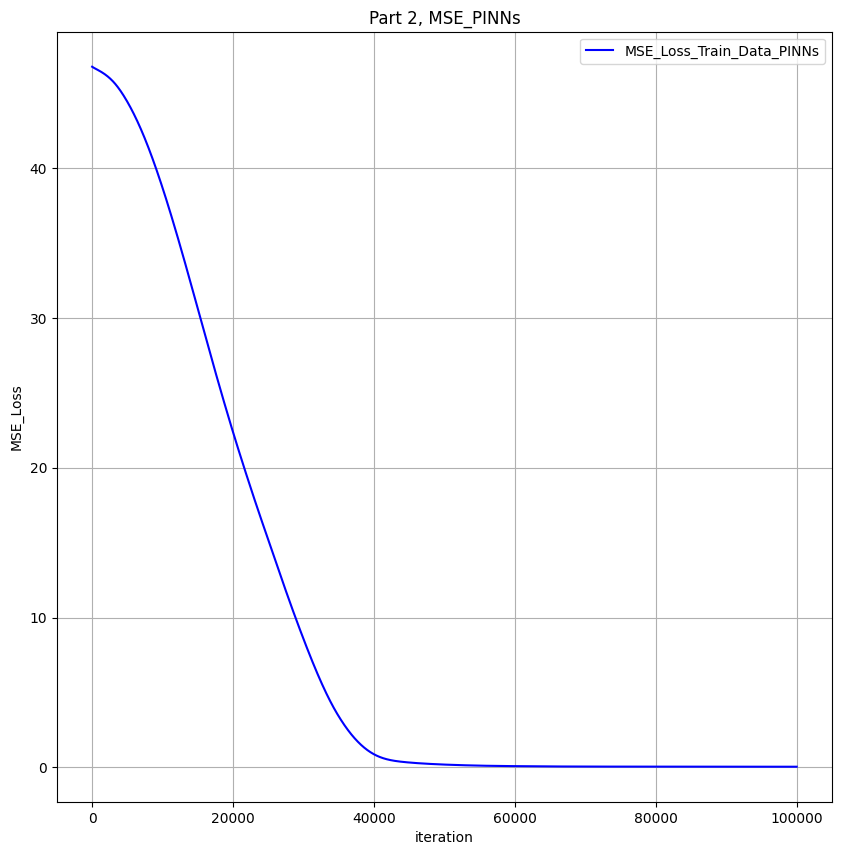

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

x__ = jnp.linspace(0, epochs, epochs)
# ax.plot(x__, jnp.array(MSE_Loss_Train_Data_PINNs), c='green')
ax.plot(x__, jnp.array(MSE_Loss_Test_Data_PINNS), c='blue')
ax.set_xlabel('iteration')
ax.set_ylabel('MSE_Loss')
plt.title('Part 2, MSE_PINNs')
plt.legend([
  'MSE_Loss_Train_Data_PINNs',
  'MSE_Loss_Test_Data_PINNS',
])
plt.grid(True)
plt.show()

Text(0.5, 1.0, '_PINNS_Method_1')

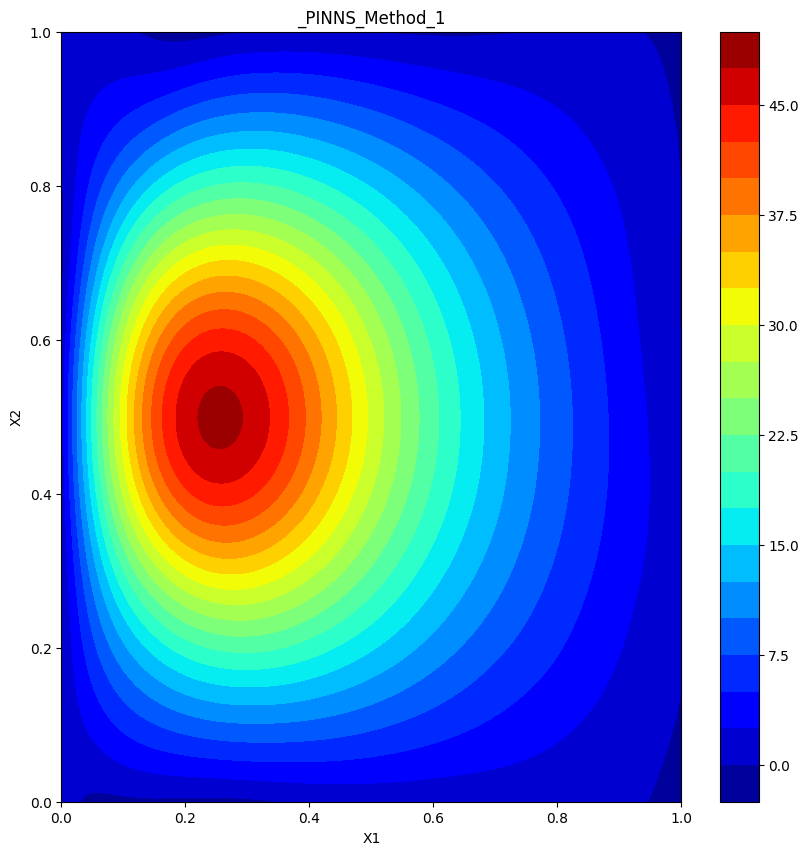

In [ ]:
testx = Forward_PINNS_Regression(params, X1, X2)
testx.shape
plotx = testx.reshape(101,101)
fig = plt.figure(figsize=(10,10))
plt.contourf(X1, X2, plotx, cmap='jet', levels = 20)
plt.colorbar()

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('_PINNS_Method_1')

part 7

In [ ]:
def Init(units, key):
    params = []
    keys = jax.random.split(key, num=5)

    w1 = jax.random.uniform(keys[0], (2, units[0]), minval=-1.0, maxval=1.0)
    b1 = jax.random.uniform(keys[1], (units[0],),   minval=-1.0, maxval=1.0)

    params.append([w1,b1])

    w2 = jax.random.uniform(keys[2], (units[0], units[1]), minval=-1.0, maxval=1.0)
    b2 = jax.random.uniform(keys[3], (units[1],), minval=-1.0, maxval=1.0)
    k = jax.random.uniform(keys[4], (1,), minval=0.5, maxval=0.5)

    params.append([w2,b2,k])
    return params


def Forward(params, x1, x2):

    input = jnp.hstack((x1.reshape(-1,1), x2.reshape(-1,1)))
    l1 = jnp.tanh(input @ params[0][0] + params[0][1])
    l2 = l1 @ params[1][0] + params[1][1]
    return l2.squeeze()


units, learning_rate, epochs = [40,1], 1e-4, 100000
params = Init(units, key)

In [ ]:
params[1][2]

Array([0.5], dtype=float32)

In [ ]:
d2y_dx1 = jit(vmap(grad(grad(Forward, 1), 1), in_axes=(None, 0, 0)))
d2y_dx2 = jit(vmap(grad(grad(Forward, 2), 2), in_axes=(None, 0, 0)))


def R(params, X):
    R = (params[1][2])*(d2y_dx1(params, X[:,0], X[:,1]) + d2y_dx2(params, X[:,0], X[:,1])) + q(X)
    return R


@jit
def Loss(params, X_data, Y_data, X):

    loss = (1/N_Model)*(jnp.mean((R(params, X_model))**2)) + (1/N_test)*(jnp.mean((Y_train - Forward(params, X_train[:,0], X_train[:,1]))**2))
    return loss

Gradients = grad(Loss)

params = Init(units, key)

In [ ]:
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)


@jit
def step(params, opt_state):
    gradients = Gradients(params, X_train, Y_train, X_model)
    updates, opt_state = optimizer.update(gradients, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state

In [ ]:
MSE_Loss_Test_Data_PINNS = []
MSE_Loss_Train_Data_PINNs = []
Regressed_K = []
for i in range(epochs):

    params, opt_state = step(params, opt_state)

    Regressed_K.append(params[1][2])

    MSE_Loss_Test_Data_PINNS.append(Loss(params, X_test, Y_test, X_model))
    MSE_Loss_Train_Data_PINNs.append(Loss(params, X_train, Y_train, X_model))

In [ ]:
Regressed_K_ = params[1][2]
Regressed_K_

Array([0.09908736], dtype=float32)

Text(0.5, 1.0, 'Part 7, k_UNKNOWN')

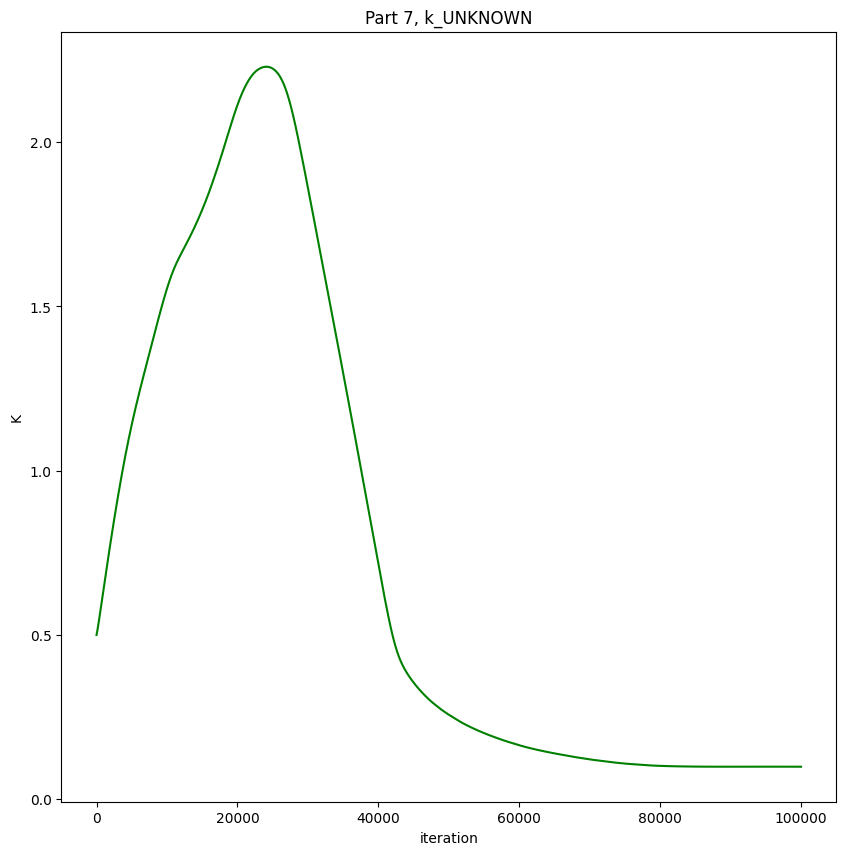

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

x__ = jnp.linspace(0, epochs, epochs)
ax.plot(x__, jnp.array(Regressed_K), c='green')
ax.set_xlabel('iteration')
ax.set_ylabel('K')
plt.title('Part 7, k_UNKNOWN')

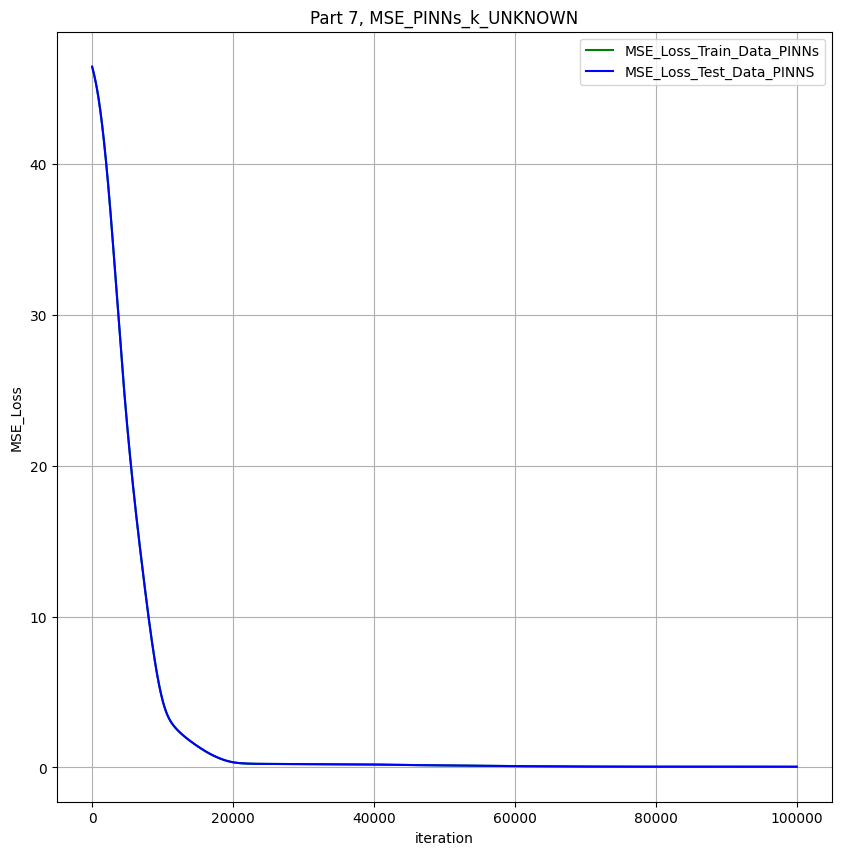

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

x__ = jnp.linspace(0, epochs, epochs)
ax.plot(x__, jnp.array(MSE_Loss_Train_Data_PINNs), c='green')
ax.plot(x__, jnp.array(MSE_Loss_Test_Data_PINNS), c='blue')

ax.set_xlabel('iteration')
ax.set_ylabel('MSE_Loss')
plt.title('Part 7, MSE_PINNs_k_UNKNOWN')
plt.legend([
  'MSE_Loss_Train_Data_PINNs',
  'MSE_Loss_Test_Data_PINNS',
])
plt.grid(True)
plt.show()

Text(0.5, 1.0, '_PINNS_Method_1_Part_7')

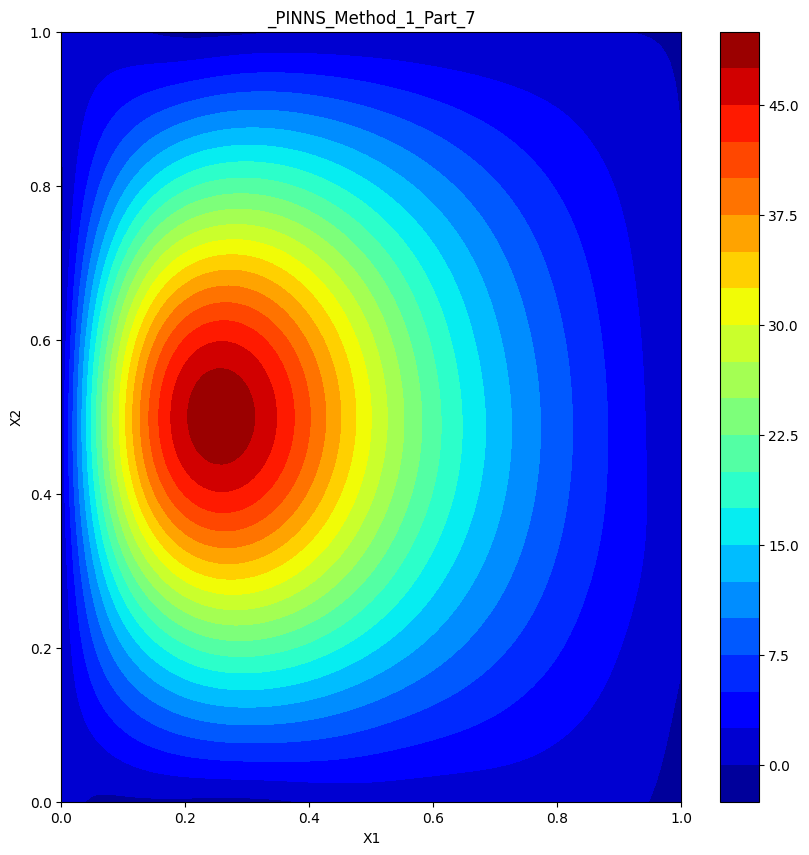

In [ ]:
Forward_ = Forward(params, X1, X2)
Forward_.shape
Forward__ = Forward_.reshape(101,101)
fig = plt.figure(figsize=(10,10))
plt.contourf(X1, X2, Forward__, cmap='jet', levels = 20)
plt.colorbar()
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('_PINNS_Method_1_Part_7')


**Method 2** (40 points)
1. In this part, you need to build a regression model based on fixed basis functions to solve the forward problem as follows:
$$T(x_1,x_2) = f(x_1,x_2;\theta) + \eta.$$
 To this end, consider Gaussian radial basis functions in the form of:
$$ f(x_1,x_2;\theta) = \sum_{i=1}^M \sum_{j=1}^M \theta_{ij} \phi_{ij}(x_1,x_2), $$
where $M$ is the number of basis functions is each direction and the basis functions are given by
$$ \phi_{ij}(x_1,x_2) = \exp{(-(x_1-\mu_i)^2/s^2)} \exp{(-(x_2-\mu_j)^2/s^2)}, \quad i,j=1, \dots, M,$$
where $\boldsymbol{\mu}=\{(\mu_i,\mu_j)\}_{i,j=1}^M$ respresents the coordiantes of where $\phi_{ij}$ bcomes maximum. Take $M=25$. This means that you have $K=M^2$ basis functions. The vector $\boldsymbol{\mu}$  is generated randomly as shown in the cell below and $s=0.25$.  We know that finding  $\theta$ requires solving a linear system of equations. In practice, linear regression problems with very large number of paramteres (large $K$) are solved iteratively, because the cost of inverting the $\Phi^T \Phi$ matrix scales with $O(K^3)$ and for large $K$, the inverse of this matrix could be cost prohibitive.   In this problem $K$ is not really that big (because of limited computational resources avialable), but you are asked to solve this probelm using an iterative approach – an approach identical to the one you used in **Method 1**, where no matrix inversion is required. To this end, repeat Parts 1-6 of  **Method 1** and take *N_Model = 500*. You do not need to solve Part 7 of **Method 1**. Note that in modifying **Method 1** to **Method 2**,  some parts of **Method 1** require minor or no changes at all.

In [ ]:
import jax
import optax
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, grad
import matplotlib.pyplot as plt

key = jax.random.PRNGKey(2)
data = jnp.load('data.npz')

In [ ]:
X1, X2, T, I = data['X1'], data['X2'], data['T'], data['I']

K  = 25*25
L = 1
k = 0.1
N_test  = 75
N_Model = 500
sigma = 2

I_train, I_test = I[N_test:], I[:N_test]

X_train = jnp.hstack((X1.reshape(-1,1)[I_train], X2.reshape(-1,1)[I_train]))
Y_train = T.ravel()[I_train] + sigma*jax.random.normal(key, shape=(len(I_train),))

X_test = jnp.hstack((X1.reshape(-1,1)[I_test], X2.reshape(-1,1)[I_test]))
Y_test = T.ravel()[I_test]

X_model = L*jax.random.uniform(key, shape=(N_Model,2))

q = lambda X: 250*jnp.exp(-20*(X[:,0]-L/6)**2-20*(X[:,1]-L/2)**2)

In [ ]:
M = 25
K  = 25*25
s  = 0.25
mu = jax.random.uniform(key, shape=(2, K))

def Init(K, key):
    return [jax.random.uniform(key, (K,1), minval=-1.0, maxval=1.0)]


def Forward(params, x1, x2):
  phi = (jnp.exp(-(x1.reshape(-1,1)- mu[0][:])**2/ s**2))*(jnp.exp(-(x2.reshape(-1,1)- mu[1][:])**2/ s**2))
  l1 = phi @ params[0]
  return l1.squeeze()

learning_rate, epochs = 1e-1, 100000
params_ = Init(K, key)

In [ ]:

@jit
def Loss(params, X_data, Y_data):

    loss = (1/N_test)*(jnp.mean((Y_data - Forward(params, X_data[:,0], X_data[:,1] ))**2))
    return loss

Gradients = grad(Loss)


In [ ]:
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params_)

@jit
def step(params_, opt_state):
    gradients = Gradients(params_, X_train, Y_train)
    updates, opt_state = optimizer.update(gradients, opt_state, params_)
    params_ = optax.apply_updates(params_, updates)
    return params_, opt_state

In [ ]:
MSE_Loss_Test_Data_Regression = []
MSE_Loss_Train_Data_Regression = []
for i in range(epochs):

    params_, opt_state = step(params_, opt_state)

    MSE_Loss_Test_Data_Regression.append(Loss(params_, X_test, Y_test))
    MSE_Loss_Train_Data_Regression.append(Loss(params_, X_train, Y_train))

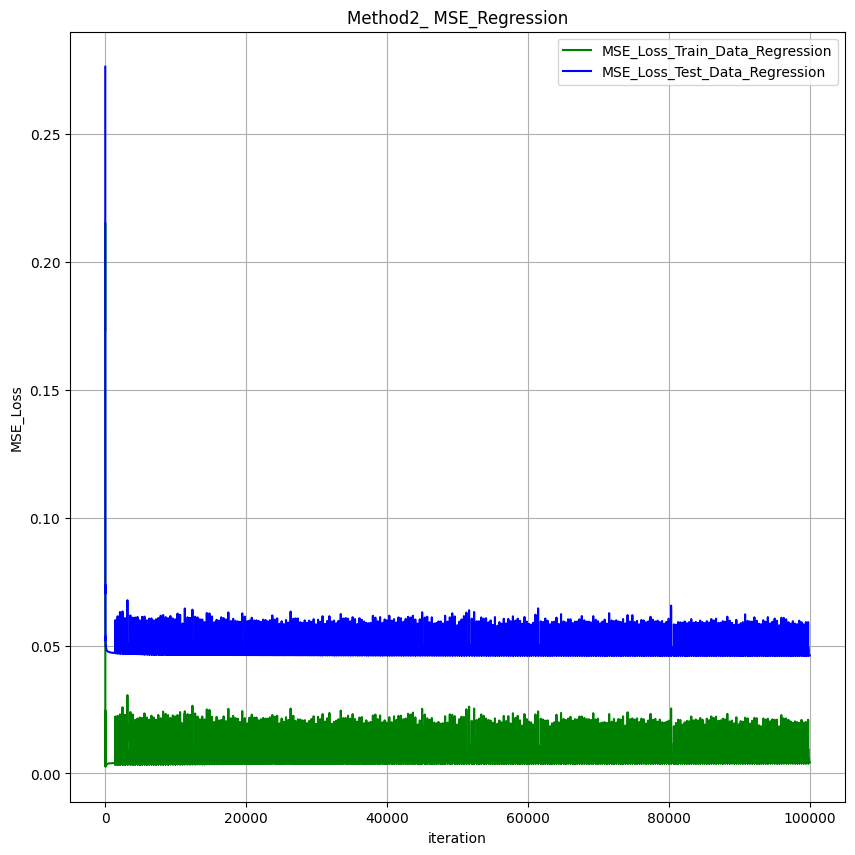

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

x__ = jnp.linspace(0, epochs, epochs)
ax.plot(x__, jnp.array(MSE_Loss_Test_Data_Regression), c='green')
ax.plot(x__, jnp.array(MSE_Loss_Train_Data_Regression), c='blue')
ax.set_xlabel('iteration')
ax.set_ylabel('MSE_Loss')
plt.title('Method2_ MSE_Regression')
plt.legend([
  'MSE_Loss_Train_Data_Regression',
  'MSE_Loss_Test_Data_Regression',
])
plt.grid(True)
plt.show()

Text(0.5, 1.0, '_Regression_Method_2')

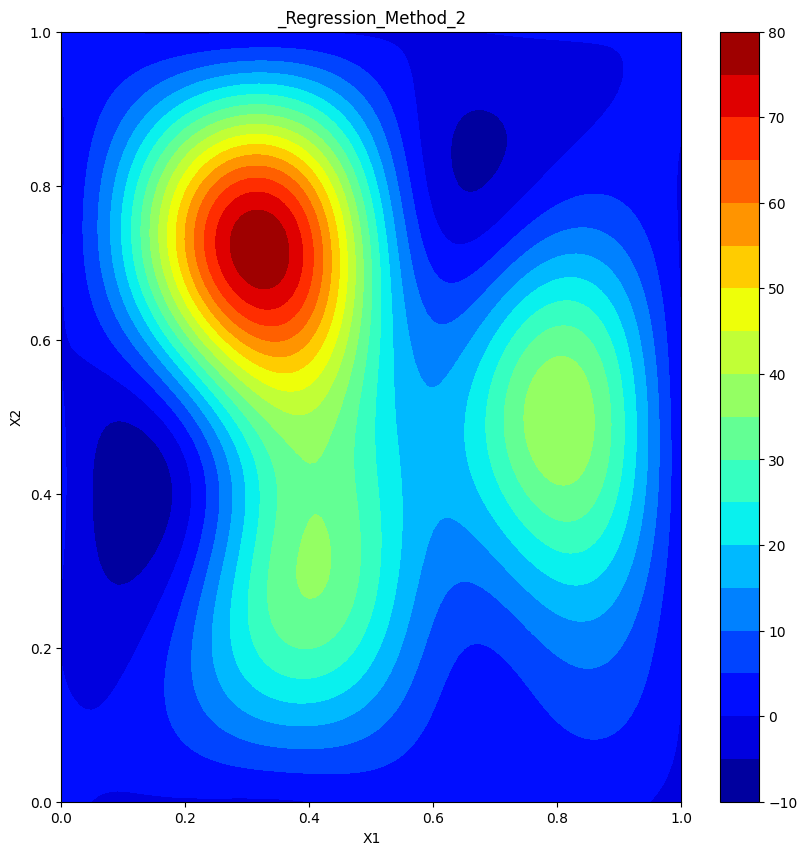

In [ ]:
testx = Forward(params_, X1, X2)
testx.shape
plotx = testx.reshape(101,101)
fig = plt.figure(figsize=(10,10))
plt.contourf(X1, X2, plotx, cmap='jet', levels = 20)
plt.colorbar()

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('_Regression_Method_2')

Method 2: Physics Informed Regression

In [ ]:
M = 25
K  = 25*25
s  = 0.25
mu = jax.random.uniform(key, shape=(2, K))

def Init(K, key):
    return [jax.random.uniform(key, (K,1), minval=-1.0, maxval=1.0)]


def Forward(params, x1, x2):
  phi = (jnp.exp(-(x1.reshape(-1,1)- mu[0][:])**2/ s**2))*(jnp.exp(-(x2.reshape(-1,1)- mu[1][:])**2/ s**2))
  l1 = phi @ params[0]
  return l1.squeeze()

learning_rate, epochs = 1e-1, 100000
params_ = Init(K, key)

In [ ]:
d2y_dx1 = jit(vmap(grad(grad(Forward, 1), 1), in_axes=(None, 0, 0)))
d2y_dx2 = jit(vmap(grad(grad(Forward, 2), 2), in_axes=(None, 0, 0)))

def R(params, X):
    R = (k)*(d2y_dx1(params, X[:,0], X[:,1]) + d2y_dx2(params, X[:,0], X[:,1])) + q(X)
    return R


@jit
def Loss(params, X_data, Y_data, X):

    loss = (1/N_Model)*(jnp.mean((R(params, X))**2)) + (1/N_test)*(jnp.mean((Y_data - Forward(params, X_data[:,0], X_data[:,1] ))**2))
    return loss

Gradients = grad(Loss)



In [ ]:
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params_)

@jit
def step(params_, opt_state):
    gradients = Gradients(params_, X_train, Y_train, X_model)
    updates, opt_state = optimizer.update(gradients, opt_state, params_)
    params_ = optax.apply_updates(params_, updates)
    return params_, opt_state

In [ ]:
MSE_Loss_Test_Data_PIR = []
MSE_Loss_Train_Data_PIR = []
for i in range(epochs):

    params_, opt_state = step(params_, opt_state)

    MSE_Loss_Test_Data_PIR.append(Loss(params_, X_test, Y_test, X_model))
    MSE_Loss_Train_Data_PIR.append(Loss(params_, X_train, Y_train, X_model))

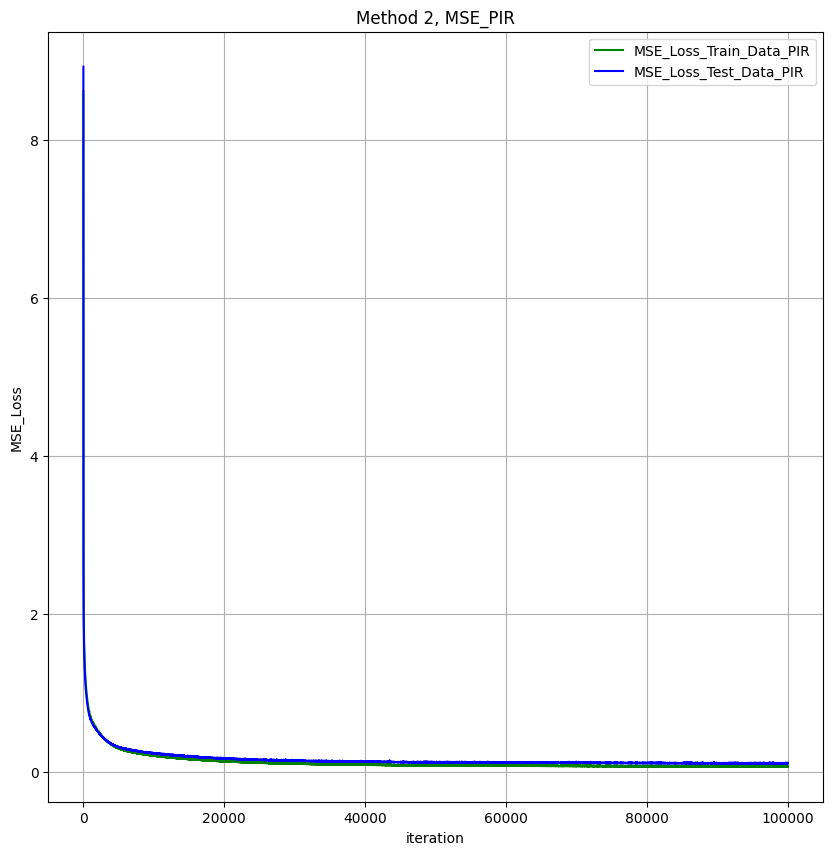

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

x__ = jnp.linspace(0, epochs, epochs)
ax.plot(x__, jnp.array(MSE_Loss_Test_Data_PIR), c='green')
ax.plot(x__, jnp.array(MSE_Loss_Train_Data_PIR), c='blue')
ax.set_xlabel('iteration')
ax.set_ylabel('MSE_Loss')
plt.title('Method 2, MSE_PIR')
plt.legend([
  'MSE_Loss_Train_Data_PIR',
  'MSE_Loss_Test_Data_PIR',
])
plt.grid(True)
plt.show()

Text(0.5, 1.0, '_Physics_Informed_Regression_Method_2')

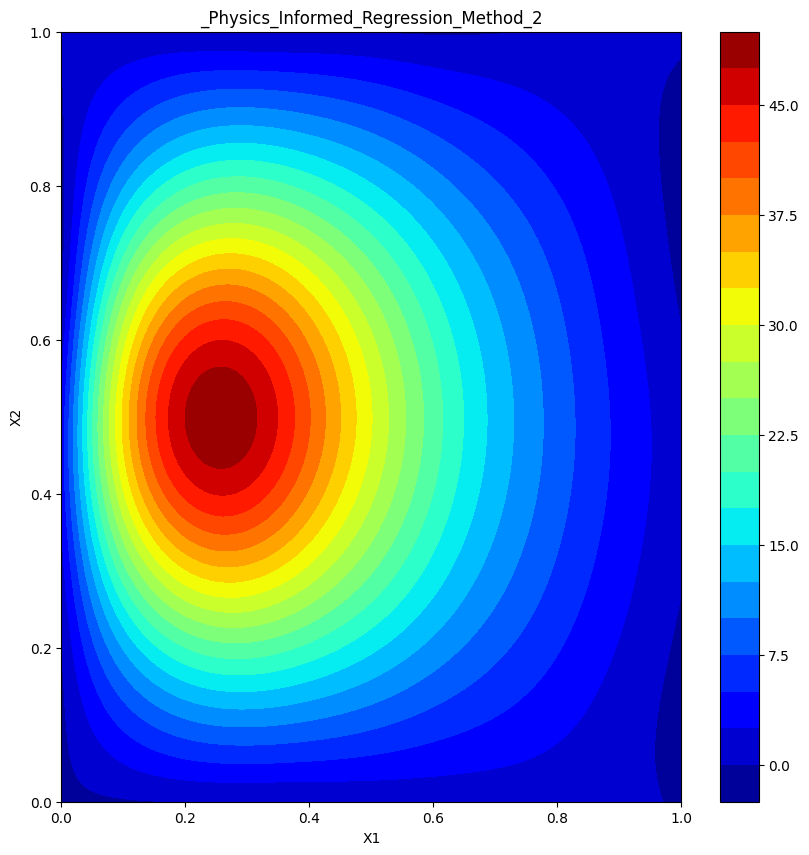

In [ ]:
testx = Forward(params_, X1, X2)
testx.shape
plotx = testx.reshape(101,101)
fig = plt.figure(figsize=(10,10))
plt.contourf(X1, X2, plotx, cmap='jet', levels = 20)
plt.colorbar()

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('_Physics_Informed_Regression_Method_2')

This code simulates the injection motion by calculating the force required to penetrate the skin to a certain depth and then using the equations of motion to simulate the depth of penetration over time. Adjust parameters like injection_angle, penetration_depth, needle_length, skin_density, and skin_thickness based on your specific scenario. Keep in mind that this is a simplified model and may not capture all aspects of a real-world injection.

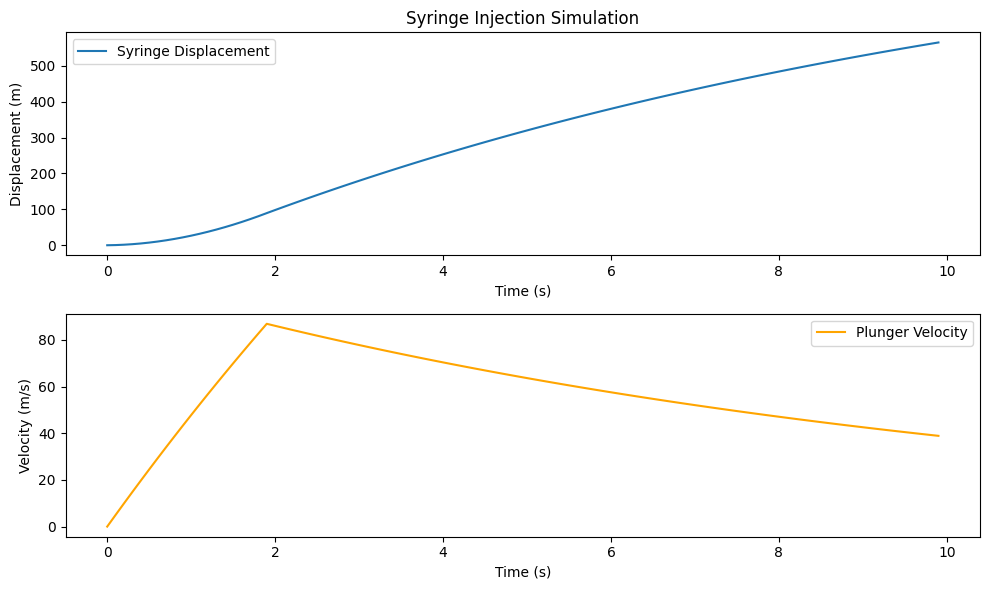

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_syringe_injection(force_function, time_steps=100, dt=0.1, initial_velocity=0):
    # Physical parameters
    mass_syringe_plunger = 0.01  # mass of the syringe plunger in kg
    viscosity_fluid = 0.001  # viscosity of the fluid in Ns/m^2
    area_piston = 0.0001  # cross-sectional area of the piston in m^2
    length_syringe = 0.1  # length of the syringe in meters

    # Simulation parameters
    time = np.arange(0, time_steps * dt, dt)
    velocity = np.zeros_like(time)
    displacement = np.zeros_like(time)

    # Initial conditions
    velocity[0] = initial_velocity

    # Simulation loop
    for i in range(1, len(time)):
        # Calculate force based on external force function
        external_force = force_function(time[i])

        # Calculate viscous damping force
        damping_force = -viscosity_fluid * velocity[i - 1]

        # Calculate net force
        net_force = external_force + damping_force

        # Calculate acceleration using Newton's second law
        acceleration = net_force / mass_syringe_plunger

        # Update velocity and displacement using numerical integration
        velocity[i] = velocity[i - 1] + acceleration * dt
        displacement[i] = displacement[i - 1] + velocity[i] * dt

    return time, displacement, velocity

# Example force function (you can replace it with your own)
def external_force_function(t):
    # Example: Apply a constant force for the first 2 seconds
    return 0.5 if t < 2 else 0

# Run simulation
time, displacement, velocity = simulate_syringe_injection(external_force_function)

# Plot results
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(time, displacement, label='Syringe Displacement')
plt.title('Syringe Injection Simulation')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, velocity, label='Plunger Velocity', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()

plt.tight_layout()
plt.show()
